In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from pyod.models.knn import KNN
from sklearn.cluster import KMeans
import seaborn as sns
from datetime import datetime, timedelta
import csv
from scipy import stats
import scipy as sp
from scipy.signal import correlate
from six.moves import cPickle as pickle
import pickle as _pickle
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import os

## Importando dados

Aqui foram criados dataframes de vários arquivos, cada arquivo corresponde a uma linha de onibus

In [2]:
# função criar dataframe
def createPkl(link):    
#     importa o arquivo pkl
    df = pd.read_pickle('./linktt/'+'link-'+link+'.pkl')
#     exclui colunas
#     df = df.drop(['_id', 'hour', 'link', 'trip_id', 'travel_id', 'month', 'weekday'], axis=1)
    df = df.drop(['_id', 'travel_id', 'month', 'weekday'], axis=1)
#     renomeia coluna ltt pelo nome do link
#     df = df.rename(columns={"ltt": name})
    return df

### Prieira vizualização dos dados.
foram removidas colunas que não tem serventia como mes e dia da semana, já que a coluna aproxlinkstart possui os dados completos de dia mes hora ano. O dataset possui 977.524 linhas de entradas de dados, restaram as colunas:

aproxlinkstart - data e hora

hour - hora

link - trecho da linha de onibus

ltt - tempo de viagem

trip_id - código da linha

In [3]:
# Importa lista com links
all_links = pd.read_csv('./linktt/links.txt', sep='\n')
# renomeia a coluna que foi criada com o nome do primero link para all_links
all_links = all_links.rename(columns={"(576, 577)": "all_links"})
# cria um dataframe dataset_pkl
dataset_pkl = pd.DataFrame()
# Concatena todos os links
for link in all_links['all_links']:
    df = createPkl(link)
    dataset_pkl = pd.concat([dataset_pkl, df], sort=True)


dataset_pkl
# Prieira vizualização dos dados, foram retiradas colnas que não tem serventia como mes e dia da semana, 
# já que a coluna aproxlinkstart possui os dados completos de dia mes hora ano 
# o dataset possui 977.524 linhas de entradas de dados

,aproxlinkstart,hour,link,ltt,trip_id
0,2017-01-02 06:26:46.054,6,"(577, 578)",192.242289,6475-10-0
1,2017-01-02 06:57:03.961,6,"(577, 578)",286.324701,6475-10-0
2,2017-01-02 07:03:42.030,7,"(577, 578)",519.623291,6475-10-0
3,2017-01-02 07:24:18.127,7,"(577, 578)",444.353503,6475-10-0
4,2017-01-02 07:40:59.560,7,"(577, 578)",682.389588,6475-10-0
...,...,...,...,...,...
7860,2017-09-29 21:04:53.677,21,"(795, 796)",107.890092,2080-10-0
7861,2017-09-29 21:32:17.581,21,"(795, 796)",85.350079,2080-10-0
7862,2017-09-29 21:41:39.458,21,"(795, 796)",89.538335,2080-10-0
7863,2017-09-29 22:10:03.770,22,"(795, 796)",61.377175,2080-10-0


## Criando um timestamp
um timestamp é uma medida de tempo unix, um numero unico que marca cada hora, mostrando um valor relativo a cada hora, uma forma de medir uma valor interativo de horas.

Foi introduzida uma coluna time_stamp_start, contendo o valor de hora transformado.

In [4]:
# função tranforma a hora do datetime
def hr_func(ts):
    return ts.hour
# Cria uma coluna com dias
dataset_pkl['day'] = [d.day for d in dataset_pkl['aproxlinkstart']]
# Cria uma coluna com as horas
dataset_pkl['day_hour'] = dataset_pkl['aproxlinkstart'].apply(hr_func) #já tem a coluna hour
# Coloca a coluna aproxlinkstart com datetime como indice
dataset_pkl.index = dataset_pkl['aproxlinkstart']
# Cria uma coluna com timestamp
dataset_pkl['time_stamp_start'] = [d.timestamp() for d in dataset_pkl['aproxlinkstart']]

dataset_pkl

,aproxlinkstart,hour,link,ltt,trip_id,day,day_hour,time_stamp_start
aproxlinkstart,,,,,,,,
2017-01-02 06:26:46.054,2017-01-02 06:26:46.054,6,"(577, 578)",192.242289,6475-10-0,2,6,1.483338e+09
2017-01-02 06:57:03.961,2017-01-02 06:57:03.961,6,"(577, 578)",286.324701,6475-10-0,2,6,1.483340e+09
2017-01-02 07:03:42.030,2017-01-02 07:03:42.030,7,"(577, 578)",519.623291,6475-10-0,2,7,1.483341e+09
2017-01-02 07:24:18.127,2017-01-02 07:24:18.127,7,"(577, 578)",444.353503,6475-10-0,2,7,1.483342e+09
2017-01-02 07:40:59.560,2017-01-02 07:40:59.560,7,"(577, 578)",682.389588,6475-10-0,2,7,1.483343e+09
...,...,...,...,...,...,...,...,...
2017-09-29 21:04:53.677,2017-09-29 21:04:53.677,21,"(795, 796)",107.890092,2080-10-0,29,21,1.506719e+09
2017-09-29 21:32:17.581,2017-09-29 21:32:17.581,21,"(795, 796)",85.350079,2080-10-0,29,21,1.506721e+09
2017-09-29 21:41:39.458,2017-09-29 21:41:39.458,21,"(795, 796)",89.538335,2080-10-0,29,21,1.506721e+09


{'whiskers': [<matplotlib.lines.Line2D at 0x1269417f0>,
 'caps': [<matplotlib.lines.Line2D at 0x126941eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x124f53da0>],
 'medians': [<matplotlib.lines.Line2D at 0x1256f3588>],
 'fliers': [<matplotlib.lines.Line2D at 0x1256f38d0>],
 'means': []}

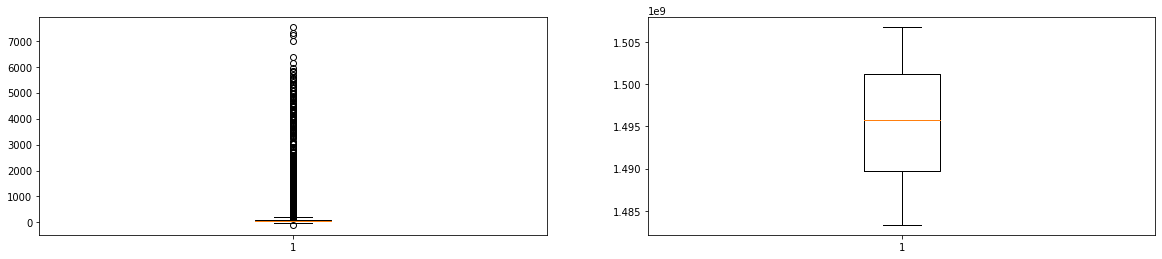

In [5]:
#  Detectando outliers
f, axarr = plt.subplots(1, 2, figsize=(20, 4))
axarr[0].boxplot(dataset_pkl["ltt"], showfliers=True)
axarr[1].boxplot(dataset_pkl["time_stamp_start"], showfliers=True)

##  Detectando outliers
Abaixo uma analise de outliers do tempo de viagem e do timestap que é uma medidade de tempo unix, existe muito valores inconsistentes no tempo de viagem (coluna ltt), enquanto o timestamp parecer estar bem mais equilibrado.


## outliers
Outro gráfico mostrando que, apesar de poucos, existem diversos valores conflitantes (outliers), etre 1000 e 7000 segundos de tempo de viagem.

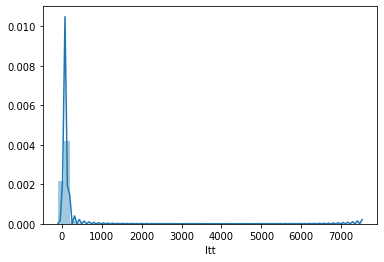

In [6]:
sns.distplot(dataset_pkl['ltt'])

# removendo outliers acima de 400

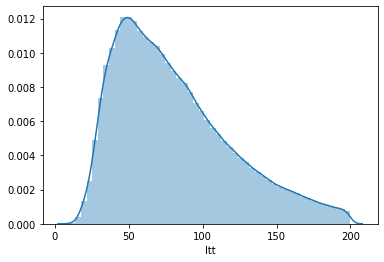

In [7]:
no_outlier = dataset_pkl[(dataset_pkl['ltt'] > 10) & (dataset_pkl['ltt'] < 200)]
sns.distplot(no_outlier['ltt'])


In [30]:
no_outlier_577 = no_outlier.loc[(no_outlier['link'] == '(577, 578)')]
no_outlier_577 = no_outlier_577.drop(columns=['aproxlinkstart', 'hour', 'link', 'trip_id', 'day', 'time_stamp_start'])

In [13]:
grafic = no_outlier[['ltt', 'day_hour']].groupby(no_outlier['day_hour']).mean()
grafic = pd.DataFrame(grafic)
grafic

,ltt,day_hour
day_hour,,
6,71.944987,6
7,79.092984,7
8,79.021480,8
9,85.288471,9
10,87.579305,10
11,85.044372,11
12,85.648941,12
13,86.119576,13
14,87.863081,14


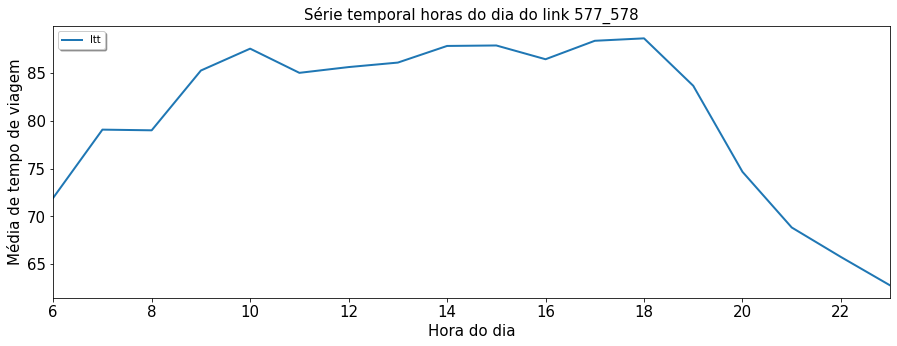

In [10]:
# no_outlier[['ltt', 'day_hour']].groupby(no_outlier['day_hour']).mean()
grafic = no_outlier['ltt'].groupby(no_outlier['day_hour']).mean()
grafic.plot(figsize=(15,5), linewidth=2, fontsize=15, marker = "")
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), shadow=True, ncol=14)
plt.title('Série temporal horas do dia do link '+ '577_578', fontsize=15)
plt.xlabel('Hora do dia', fontsize=15);
plt.ylabel('Média de tempo de viagem', fontsize=15);

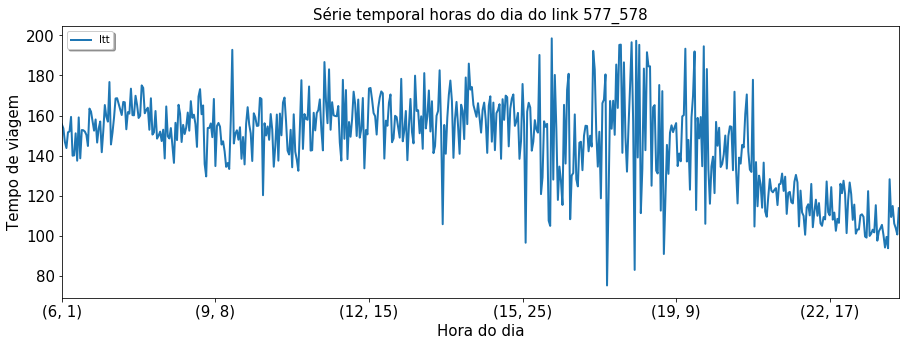

In [11]:
link_577_578_ltt = no_outlier.loc[(no_outlier['link'] == '(577, 578)')]
# link_ltt = no_outlier.loc[(no_outlier['link'] == '(577, 578)')].groupby(['day_hour', 'day'], as_index=True )['ltt'].mean().unstack()

link_ltt = link_577_578_ltt.groupby(['day_hour', 'day'])['ltt'].mean()
link_ltt

link_ltt.plot(figsize=(15,5), linewidth=2, fontsize=15, marker = "")
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), shadow=True, ncol=14)
plt.title('Série temporal horas do dia do link '+ '577_578', fontsize=15)
plt.xlabel('Hora do dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);




In [14]:
# X = link_577_578_ltt.iloc[:1000, 3:4]
# X

# y = link_577_578_ltt.iloc[:1000, 6:7]
# y

y = grafic.iloc[:, 0:1]
X = grafic.iloc[:, 1:2]
# grafic

# scaler_x = StandardScaler()
# X_one = scaler_x.fit_transform(X)

# scaler_y = StandardScaler()
# Y_one = scaler_y.fit_transform(y)

# model_regressor = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_regressor = SVR(kernel = 'rbf', degree=4, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_regressor.fit(X, y)

/Users/jamalmalik/opt/anaconda2/envs/datascience/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=4, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [15]:
model_regressor.score(X, y)

0.4265303105800495

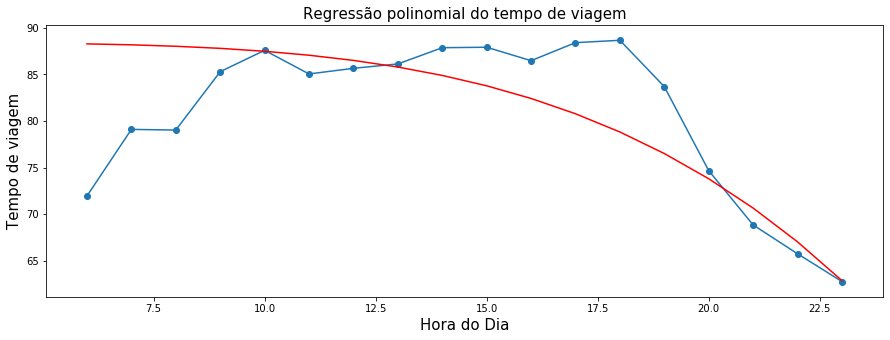

In [16]:

plt.figure(figsize=(15,5))

plt.plot(X, y)
plt.scatter(X, y)

plt.plot(X, model_regressor.predict(X), color='red')
plt.title('Regressão polinomial do tempo de viagem', fontsize=15)
plt.xlabel('Hora do Dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);

In [75]:
# X = link_577_578_ltt.iloc[:1000, 3:4]
# X

# y = link_577_578_ltt.iloc[:1000, 6:7]
# y

y_all = no_outlier_577.iloc[:, 0:1]
X_all = no_outlier_577.iloc[:, 1:2]


# scaler_x = StandardScaler()
# X_one = scaler_x.fit_transform(X)

# scaler_y = StandardScaler()
# Y_one = scaler_y.fit_transform(y)

# model_regressor_all = SVR(kernel='rbf')
model_regressor_all = SVR(kernel = 'sigmoid', degree=6, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_regressor_all.fit(X_all, y_all)


/Users/jamalmalik/opt/anaconda2/envs/datascience/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=6, epsilon=0.1, gamma='scale',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [76]:
model_regressor_all.score(X, y)

-141.21626580788273

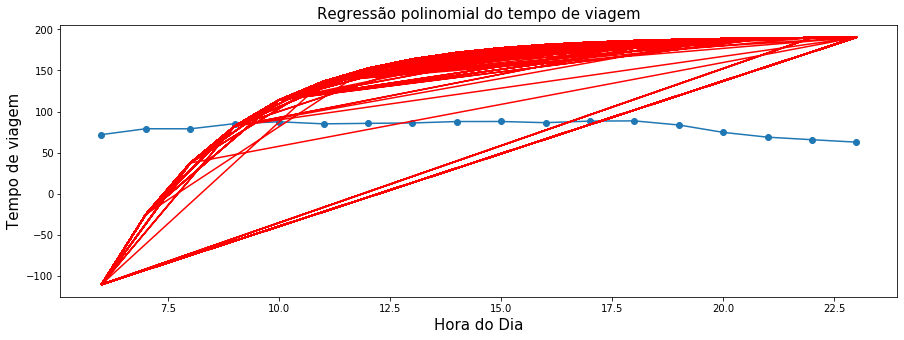

In [77]:
plt.figure(figsize=(15,5))

plt.plot(X, y)
plt.scatter(X, y)

plt.plot(X_all, model_regressor_all.predict(X_all), color='red')
plt.title('Regressão polinomial do tempo de viagem', fontsize=15)
plt.xlabel('Hora do Dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);

In [78]:

mod = sm.RecursiveLS(X, y)
res = mod.fit()


/Users/jamalmalik/opt/anaconda2/envs/datascience/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[0.08339705 0.08619136 0.09150693 0.0955936  0.0999644  0.10529627
 0.11070776 0.11617392 0.12152054 0.12693785 0.13254078 0.13801297
 0.14349571 0.14933421 0.15558057 0.16198961 0.16848703 0.1750522 ]
                ltt
day_hour           
6         71.944987
7         79.092984
8         79.021480
9         85.288471
10        87.579305
11        85.044372
12        85.648941
13        86.119576
14        87.863081
15        87.912493
16        86.469703
17        88.403451
18        88.658478
19        83.687546
20        74.668847
21        68.838123
22        65.743680
23        62.764089


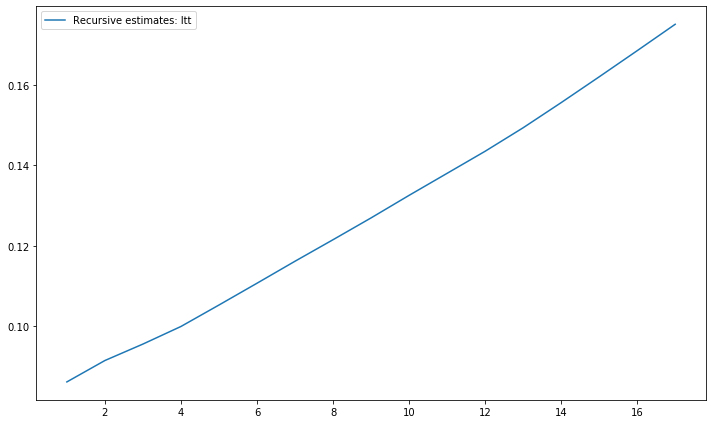

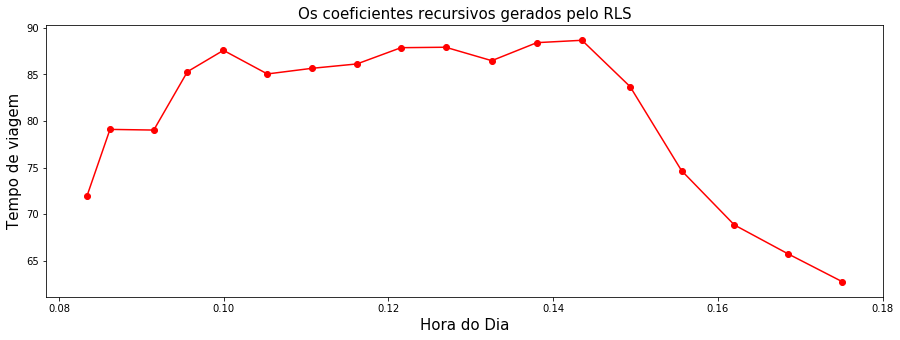

In [79]:

print(res.recursive_coefficients.filtered[0])
print(y)
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10,6));


plt.figure(figsize=(15,5))

# plt.plot(X, y)
# plt.scatter(X, y)

plt.plot(res.recursive_coefficients.filtered[0], y, color='red')
plt.scatter(res.recursive_coefficients.filtered[0], y, color='red')
plt.title('Os coeficientes recursivos gerados pelo RLS', fontsize=15)
plt.xlabel('Hora do Dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);




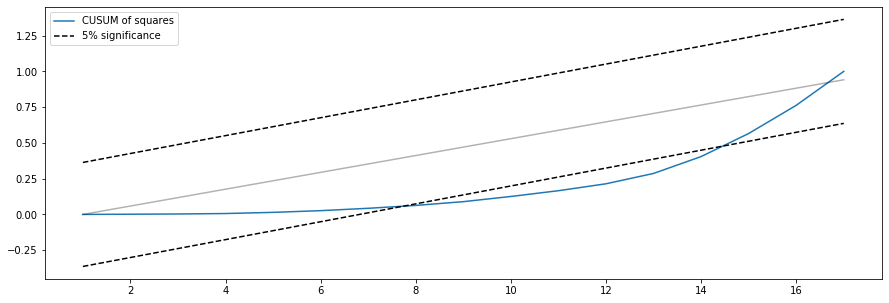

In [80]:
# plt.figure(figsize=(15,5))
res.plot_cusum_squares(figsize=(15,5));


In [81]:

mod_all = sm.RecursiveLS(X_all, y_all)
res_all = mod_all.fit()



/Users/jamalmalik/opt/anaconda2/envs/datascience/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[0.03121061 0.03870732 0.04522625 ... 0.09056185 0.09057666 0.0905884 ]
                ltt
day_hour           
6         71.944987
7         79.092984
8         79.021480
9         85.288471
10        87.579305
11        85.044372
12        85.648941
13        86.119576
14        87.863081
15        87.912493
16        86.469703
17        88.403451
18        88.658478
19        83.687546
20        74.668847
21        68.838123
22        65.743680
23        62.764089


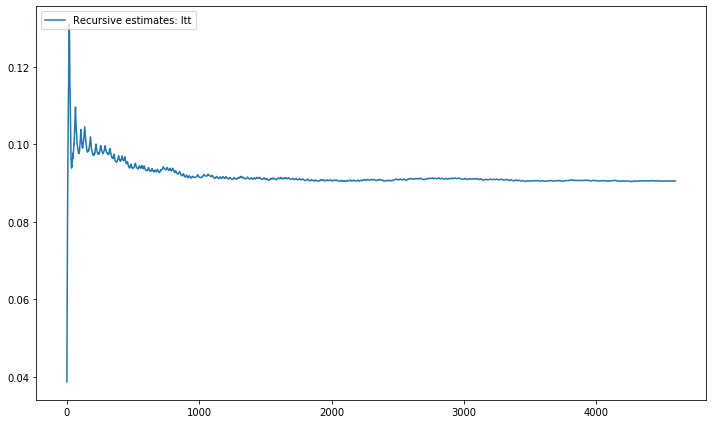

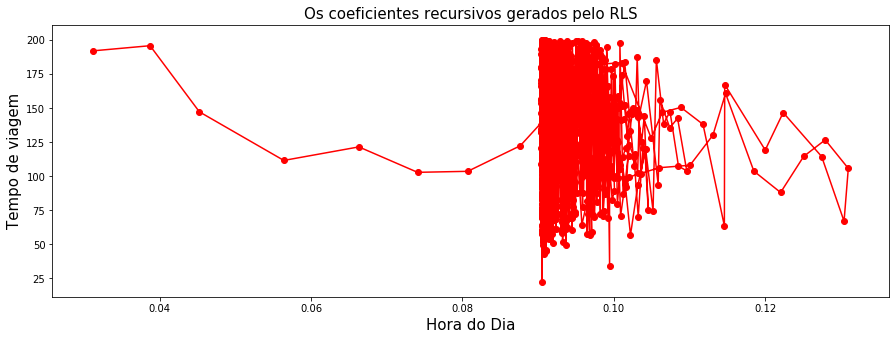

In [85]:
print(res_all.recursive_coefficients.filtered[0])
print(y)
res_all.plot_recursive_coefficient(range(mod_all.k_exog), alpha=None, figsize=(10,6));


plt.figure(figsize=(15,5))

# plt.plot(X, y)
# plt.scatter(X, y)

plt.plot(res_all.recursive_coefficients.filtered[0], y_all, color='red')
plt.scatter(res_all.recursive_coefficients.filtered[0], y_all, color='red')
plt.title('Os coeficientes recursivos gerados pelo RLS', fontsize=15)
plt.xlabel('Hora do Dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);

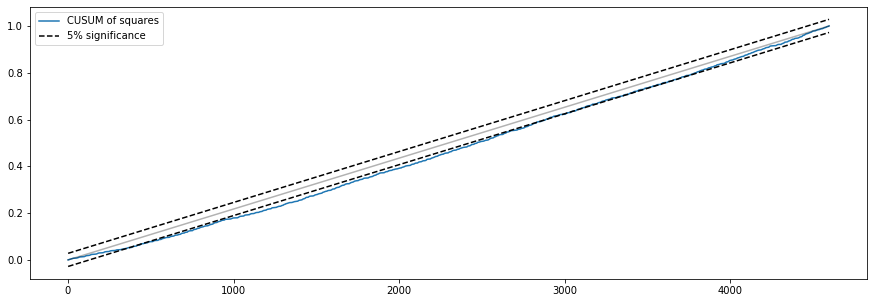

In [84]:
res_all.plot_cusum_squares(figsize=(15,5));